# **Used Cars Price Prediction**

Purpose: Build a model that identifies features that influence used car prices

In [130]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#import ignore warnings
import warnings
warnings.filterwarnings('ignore')

#import dataset
car = pd.read_csv('used_cars.csv')

### Data Overview
- Observations
- Sanity checks

In [131]:
print(f'We have {car.shape[0]} rows and {car.shape[1]} columns in our data set.\n')

'''
after viewing .head(), my initial observations would be
to drop the serial number column as it does not provide any
feature information, as well as to create a new column that
isolates the brand of car from the model name (i.e. only hyundai instead
of hyundai creta..). Next I'll check for duplicate and missing values and
other discrepancies in the dataset before moving on to EDA.
'''
#create a copy of the df

df = car.copy(deep = True)
df = df.drop('S.No.', axis = 1) #drop 'S.No' col

#check data types, treat missing values
df.info()

print('\nit looks like cols Mileage, Engine, Power, Seats, New_price and Price')
print('have some missing values, lets see how many there are:')
print('\nMissing values by column:')
print(df.isnull().sum()) 
total_missing = df.isnull().sum().sum() 

print('\n Percentage of Missing Values:')
print(round((df.isnull().sum() / df.shape[0] * 100), 2))

print(f'\nWe have a total of {total_missing} values missing in our dataset,')
print('with a majority being from the new_price column.\n')

#check for duplicates
duplicate = df[df.duplicated()]
df[df.duplicated(keep = False)] 

'''
Observation: There is one set of duplicates. In the original dataset cars these
two rows have different serial numbers but I think its because they were
entered on two separate occasions because all the other information such as
mileage, dealership, model etc are all the same so I'm going to drop one of the
duplicates. If I was working this job in reality I would first contact the dealership
to determine whether this was a duplicate before dropping.
'''
#drop duplicate
df.drop_duplicates(inplace = True) 
df.shape 
print('View nunique values:')
print(df.nunique()) #check for unique values in each column


We have 7253 rows and 14 columns in our data set.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7253 entries, 0 to 7252
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               7253 non-null   object 
 1   Location           7253 non-null   object 
 2   Year               7253 non-null   int64  
 3   Kilometers_Driven  7253 non-null   int64  
 4   Fuel_Type          7253 non-null   object 
 5   Transmission       7253 non-null   object 
 6   Owner_Type         7253 non-null   object 
 7   Mileage            7251 non-null   float64
 8   Engine             7207 non-null   float64
 9   Power              7078 non-null   float64
 10  Seats              7200 non-null   float64
 11  New_price          1006 non-null   float64
 12  Price              6019 non-null   float64
dtypes: float64(6), int64(2), object(5)
memory usage: 736.8+ KB

it looks like cols Mileage, Engine, Power, Seats, New_pri

In [132]:
#Feature engineering: create a new 'Brand' feature that splits Name of car from maker
#this way we can make brand an additional feature for our dataset

print('\nAdding a Brand column to our dataset:')
brand = df['Name'].str.split(' ', n = 1, expand = True)

df['Brand'] = brand[0] #append to dataset
df['Brand'].value_counts() #check work to make sure new col is created properly


Adding a Brand column to our dataset:


Brand
Maruti           1444
Hyundai          1340
Honda             742
Toyota            507
Mercedes-Benz     380
Volkswagen        374
Ford              351
Mahindra          331
BMW               312
Audi              285
Tata              228
Skoda             202
Renault           170
Chevrolet         151
Nissan            117
Land               67
Jaguar             48
Fiat               38
Mitsubishi         36
Mini               31
Volvo              28
Jeep               19
Porsche            19
Datsun             17
Force               3
ISUZU               3
Isuzu               2
Bentley             2
Smart               1
Ambassador          1
Lamborghini         1
Hindustan           1
OpelCorsa           1
Name: count, dtype: int64

# Observations:

- Our dataset has 7253 records and 14 columns
- The 'S. No.' column is an ID column for each car and is not likely to have any influence on our dependent variable ('Price') so I will drop it
- Columns [Mileage, Engine, Power, Seats, New_price, Price] contain missing values
- The majority of missing values are from the 'New_price' column at ~86% and the next largest being the 'Price' column at ~17%
- The 'Name' column has so many unique values that it will be difficult to work with as is, so I created a new column called 'Brand' to store the brand info extracted from each record in 'Name'
- Dropped the one duplicate found


## **Exploratory Data Analysis**

In [133]:
print('\nView summary stats:')
print(df.describe().T) #view summary stats for numerical cols

print('\nthe maximum mileage in our summary statistics is 6,500,000')
print('which is impossible and likely a typo. Lets view the column:')

df['Kilometers_Driven'].sort_values(ascending = False).head(10)
print(df.loc[df['Kilometers_Driven'] == 6500000]) #view record


View summary stats:
                    count          mean           std      min        25%  \
Year               7252.0   2013.365830      3.254405  1996.00   2011.000   
Kilometers_Driven  7252.0  58699.986900  84433.505524   171.00  34000.000   
Mileage            7250.0     18.141738      4.562492     0.00     15.170   
Engine             7206.0   1616.590064    595.324779    72.00   1198.000   
Power              7077.0    112.764474     53.497297    34.20     75.000   
Seats              7199.0      5.280456      0.809327     2.00      5.000   
New_price          1006.0     22.779692     27.759344     3.91      7.885   
Price              6019.0      9.479468     11.187917     0.44      3.500   

                        50%         75%         max  
Year                2014.00   2016.0000     2019.00  
Kilometers_Driven  53429.00  73000.0000  6500000.00  
Mileage               18.16     21.1000       33.54  
Engine              1493.00   1968.0000     5998.00  
Power          

# Outlier Treatment

- The maximum value for the 'Kilometers_Driven' column was 6,500,000 which is impossible and likely a typo. This value was changed to 650,000


In [134]:
df['Kilometers_Driven'] = df['Kilometers_Driven'].replace(6500000, 650000) #replace value
print('\nView new Kilometers_Driven col after replacing value:')
df['Kilometers_Driven'].sort_values(ascending = False).head(10) #check work




View new Kilometers_Driven col after replacing value:


340     775000
1860    720000
2328    650000
358     620000
2823    480000
3092    480000
4491    445000
6921    350000
3649    300000
1528    299322
Name: Kilometers_Driven, dtype: int64

# Observations

- Brand, Name, Location, Fuel_Type, Transmission and Owner_Type are of the object data type and the rest are of the numeric datatype
- Year could fit into either category technically but I've place it in the numeric category as it can serve as a useful predictive variable in regression analysis
- This data set contains in total 33 brands, 11 locations, 5 fuel types, 2 transmission types and 4 owner types, as well as 2041 names. None of our categorical columns contain missing values
- Within the dataset, the following are the most popular of our categorical items: Brand - Maruti, Name - Mahindra XUV500 W8 2WD, Location - Mumbai, Fuel_Type - Diesel, Transmission - Manual, Owner_Type - first
- Cars in this dataset were made in years spanning 1996 to 2019
- The average amount of km driven  is ~57,000
- Both the average and median car Mileage is ~18 kmpl
- The average power displacement is ~1616 bhp
- The average and most frequent amount of seats in a car is 5
- On average, it appears that the Price of a car is sold for is around half of what its original New_price is. It is important to note however that this may not be a reliable observation as these two columns contain the majority of our missing values
- On average, the sale price of used cars is ~947,000 INR


## **Univariate Analysis**

In [135]:
#split cols into categorical and numerical for analysis

df_cat = df[['Brand', 'Name', 'Location', 'Fuel_Type', 'Transmission', 'Owner_Type']]

#decided to put year in df_num even though its technically categorical because it can
#serve as a useful predictive variable in regression analysis
df_num = df[['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'New_price', 'Price']]


Brand


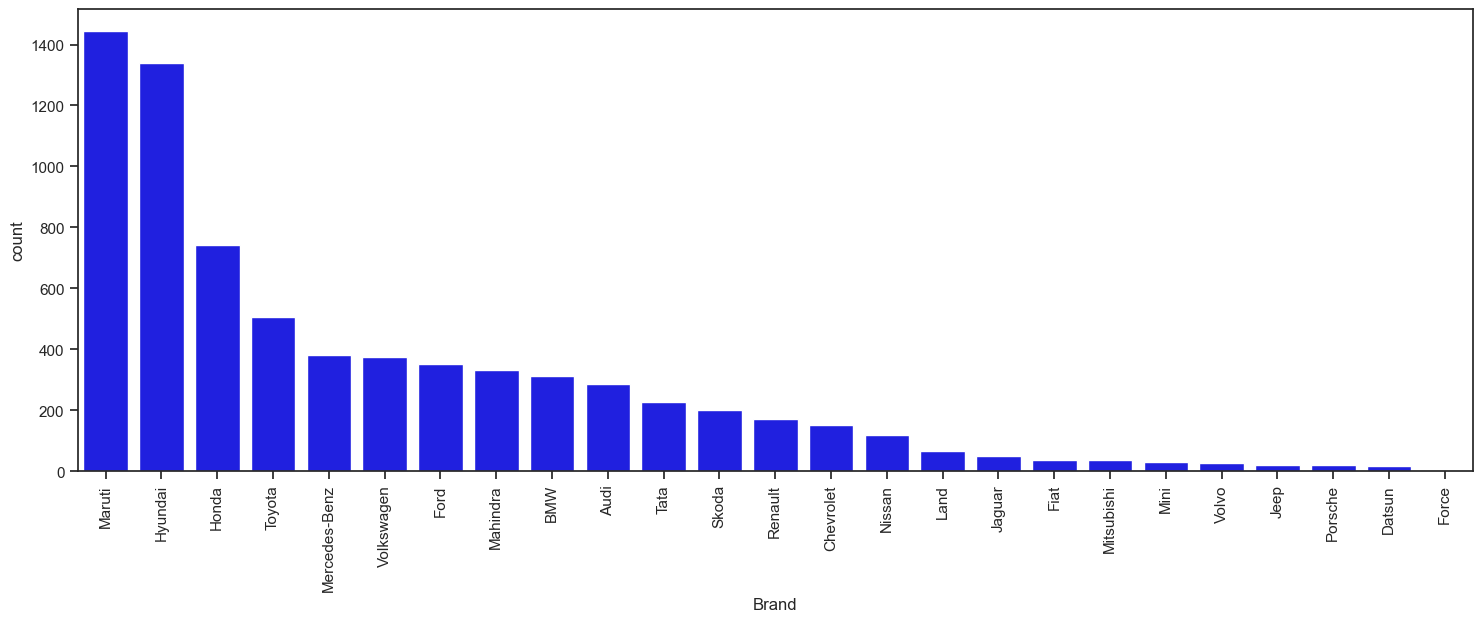

Location


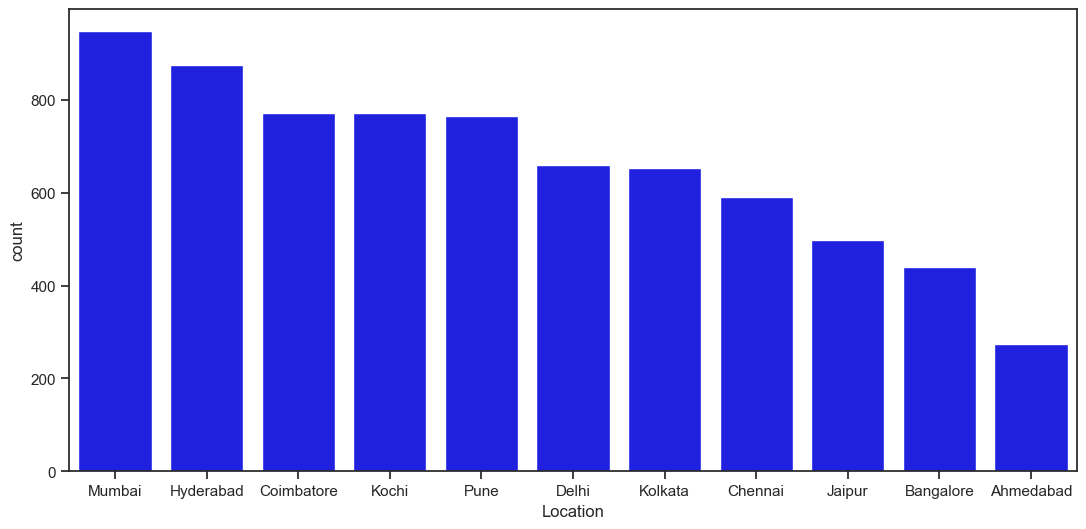

Fuel_Type


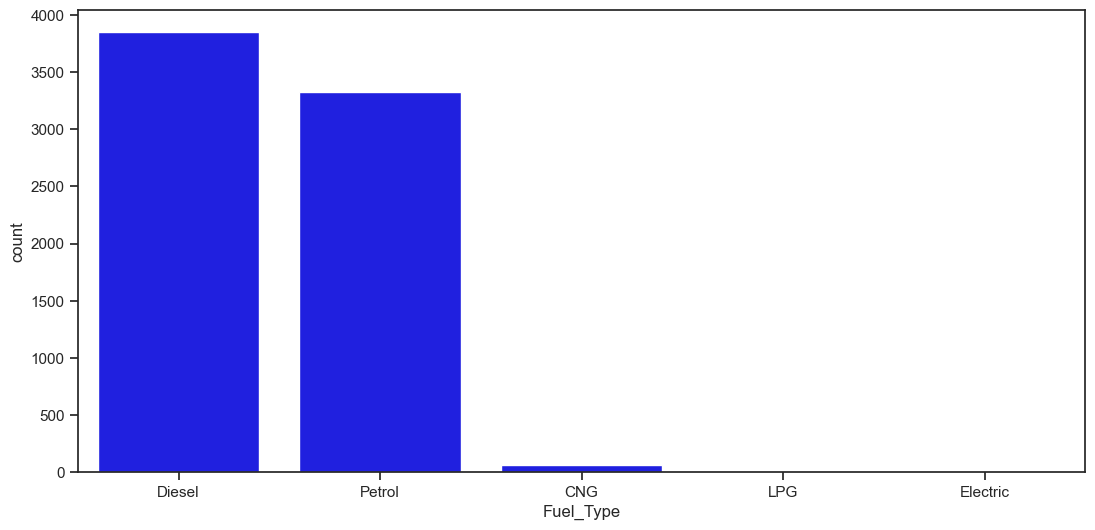

Transmission


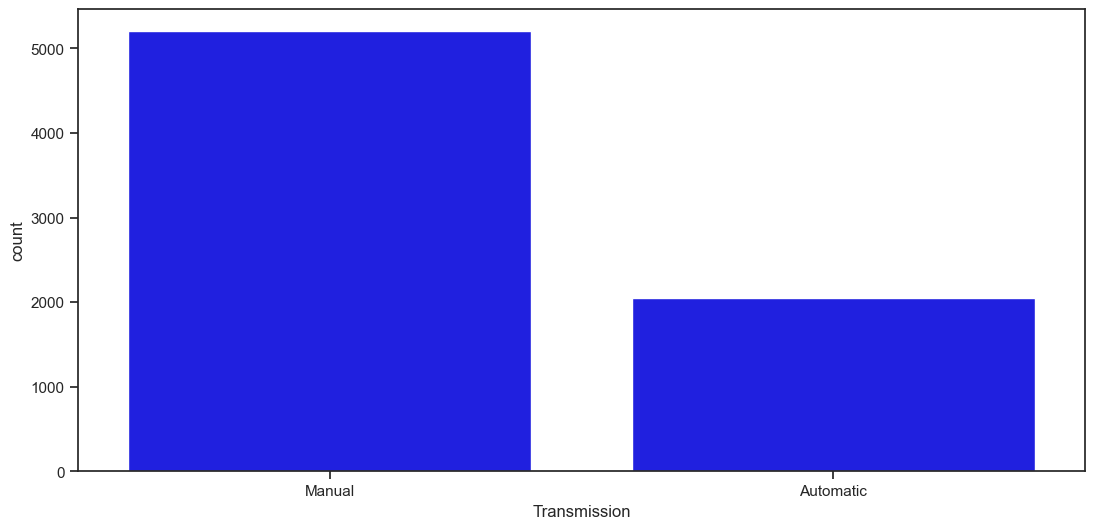

Owner_Type


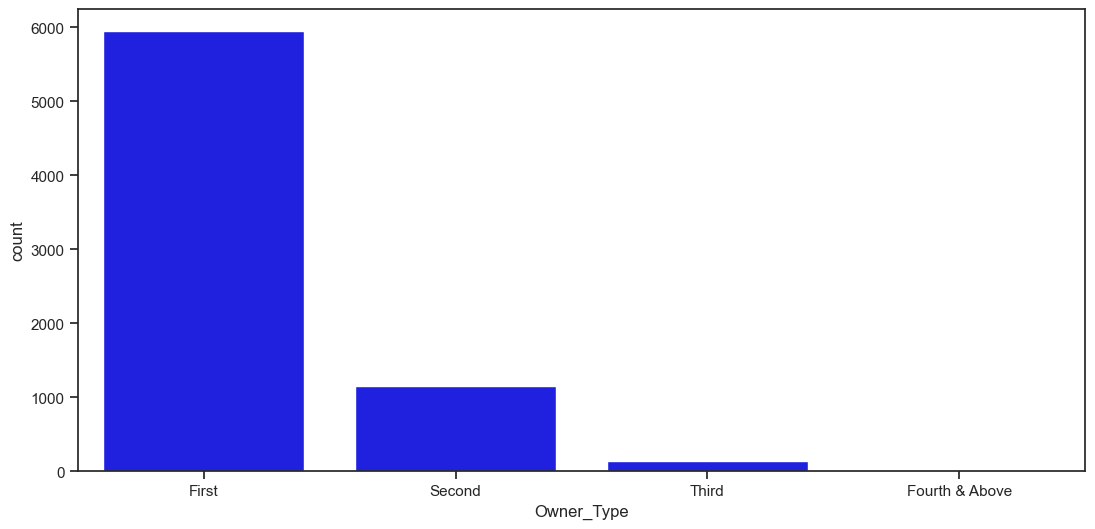

Year


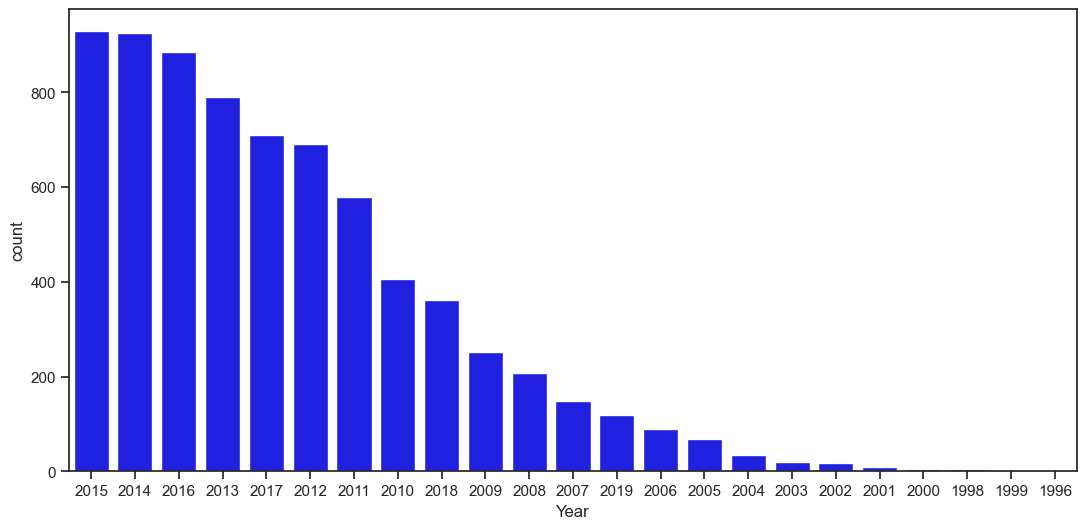

In [136]:
#check for distribution of categorical col in data

#plot only the most 25 frequently appearing brands for ease of data presentation
print('Brand')
fig = plt.figure(figsize = (18, 6))
sns.countplot(x = 'Brand', data = df_cat, color = 'blue', order = df_cat['Brand'].value_counts().iloc[:25].index);
plt.xticks(rotation = 90);
plt.show()

#remove Brand and Name from this because they are so many different values in both categories
cat_vals = ['Location', 'Fuel_Type', 'Transmission', 'Owner_Type', 'Year']
for col in cat_vals:
  print(col)
  fig = plt.figure(figsize = (13, 6))
  sns.countplot(x = col, data = df, color = 'blue', order = df[col].value_counts().index);
  plt.show()


Name


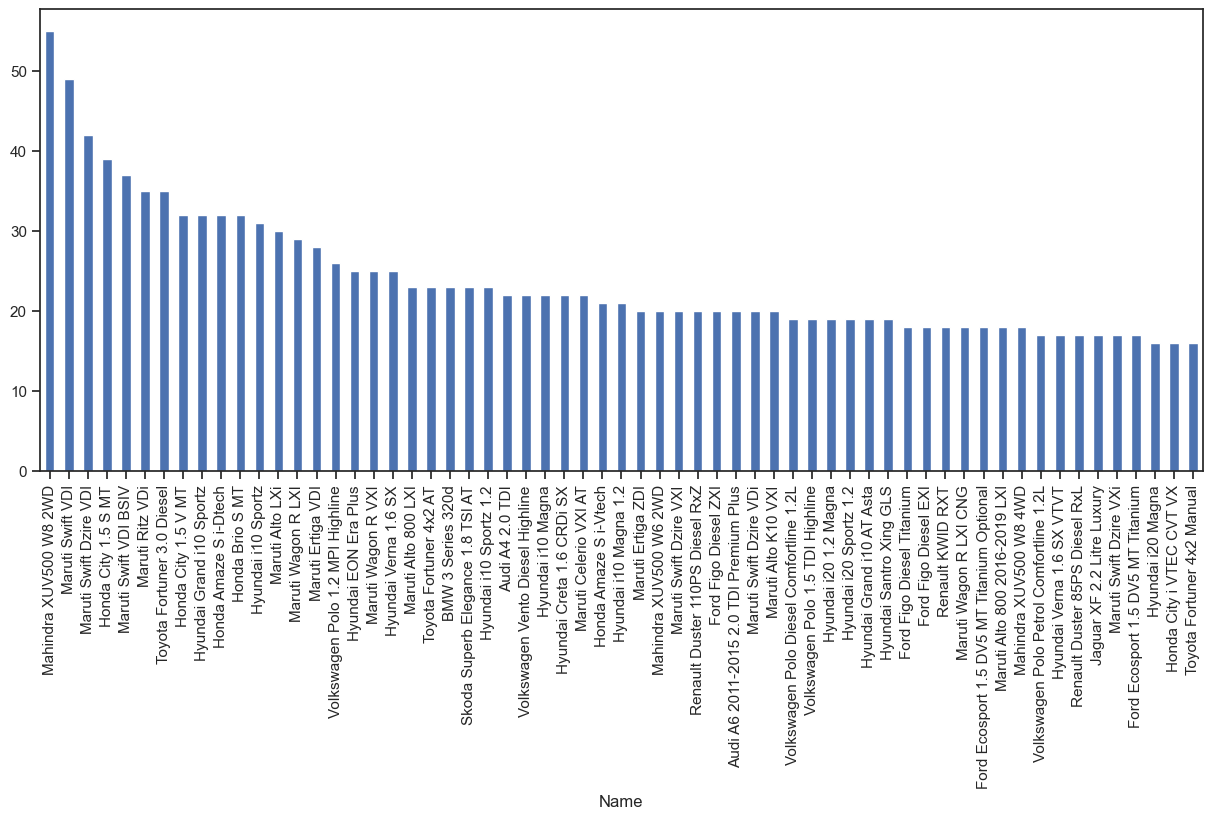

In [58]:
#View Name cols where values > 15
print('Name')
df['Name'].value_counts()[:61].sort_values(ascending = False).plot(kind = 'bar', figsize = (15, 6))
plt.show()


#  Observations

- Maruti, Hyundai and then Honda are the most popular car brands in this dataset
- Diesel and Petrol make up the majority (~98%) of all fuel types
- Around 82% of cars within this dataset are on their first round of ownership. It is extremely rare for a car to have a third or higher ownership
- There is a fairly even distribution of car locations although the locations Mumbai, Hyderabad, Coimbatore, Kochi, Pune, Delhi and Kolkata are most popular. This makes sense as they are large cities
- Most of the cars in this dataset were made from 2011 to 2017, with the most frequent being years 2015 and 2014
- There is a fairly even distribution of different car names irrespective of Brand. Name is not likely to be a useful predictive column for our analysis because of this and I may consider dropping it

Year
Skew : -0.84


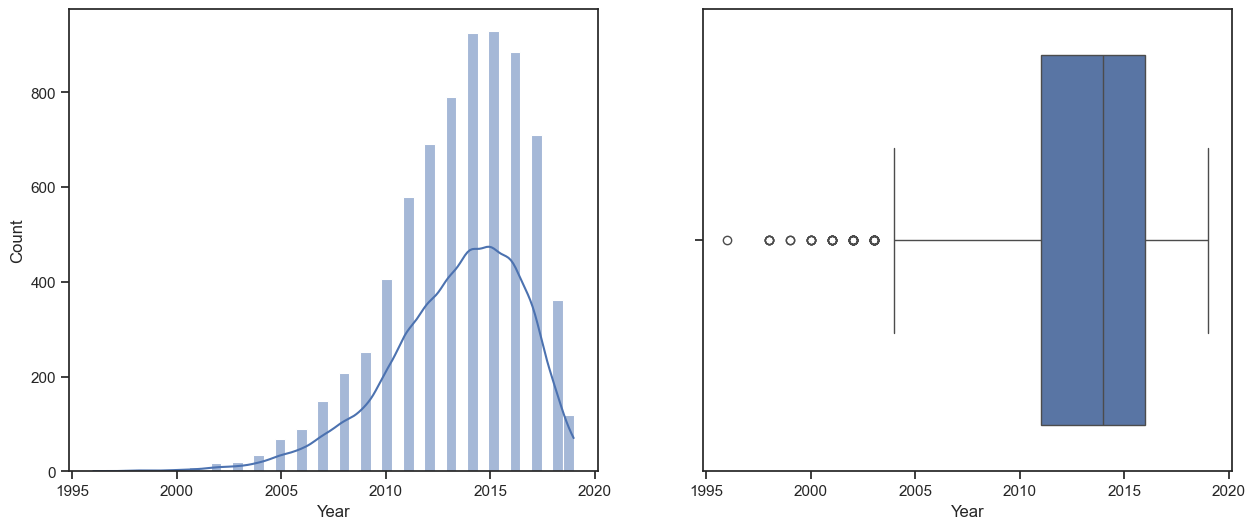

Kilometers_Driven
Skew : 4.15


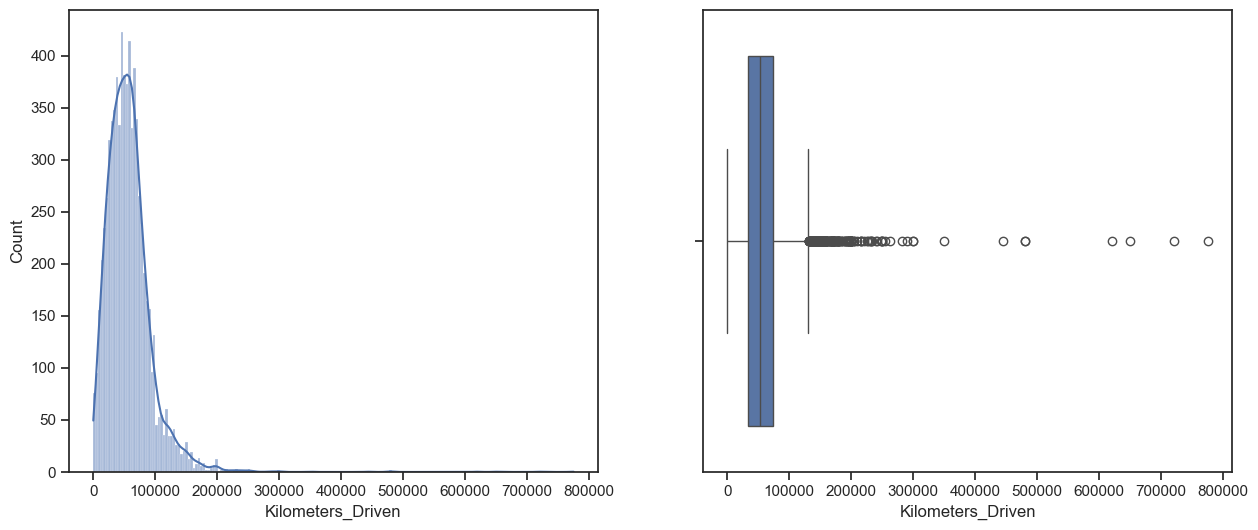

Mileage
Skew : -0.44


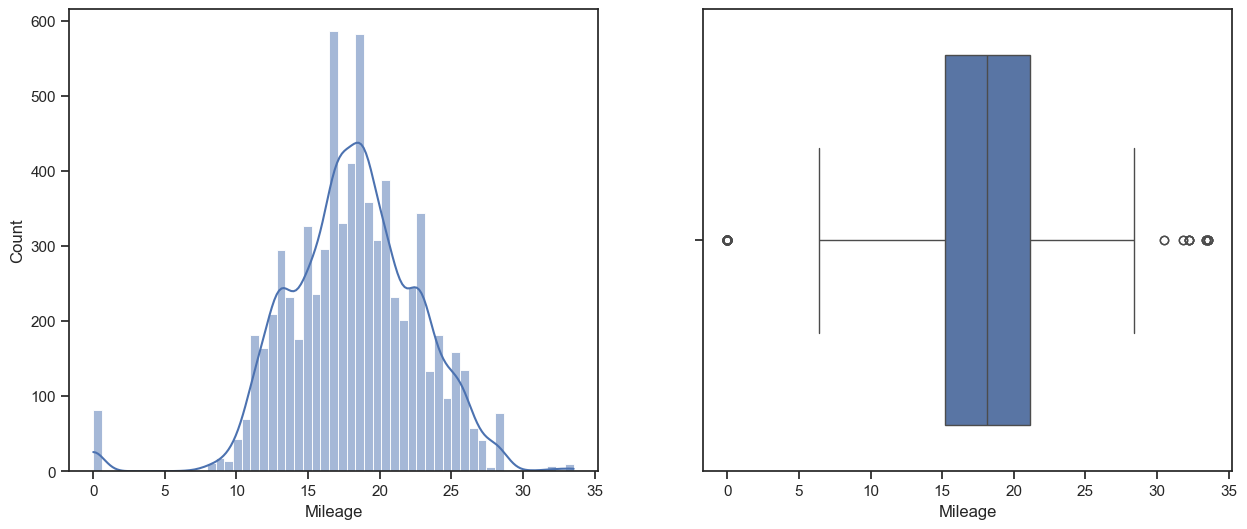

Engine
Skew : 1.41


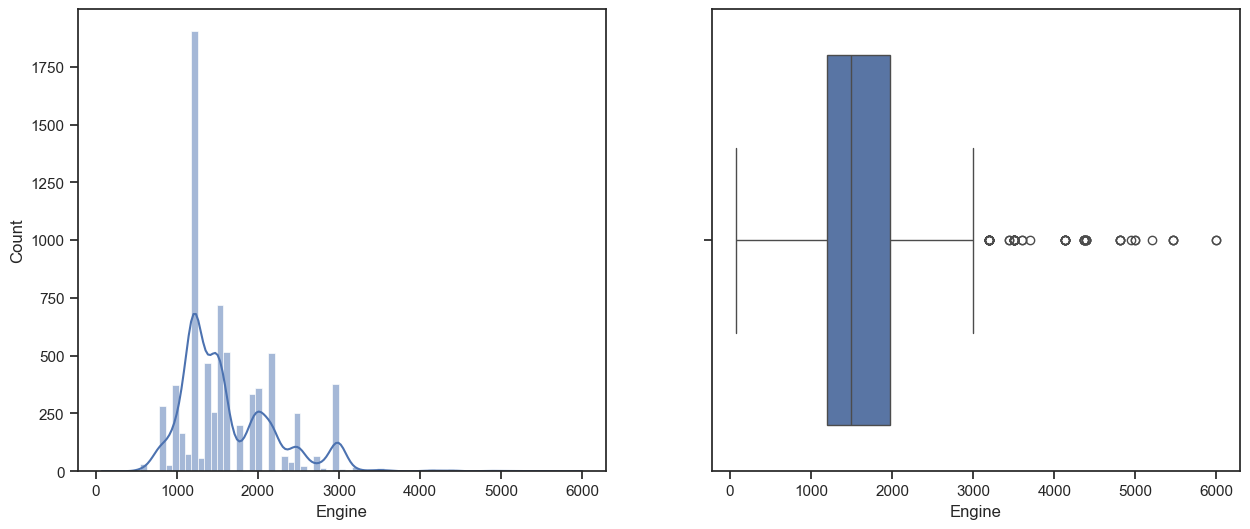

Power
Skew : 1.96


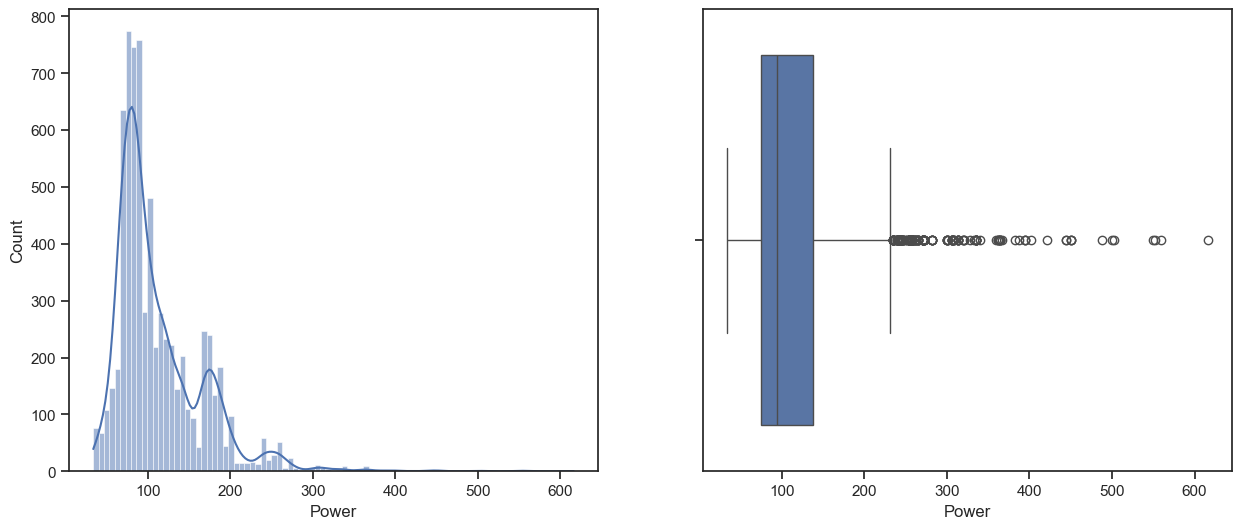

Seats
Skew : 1.95


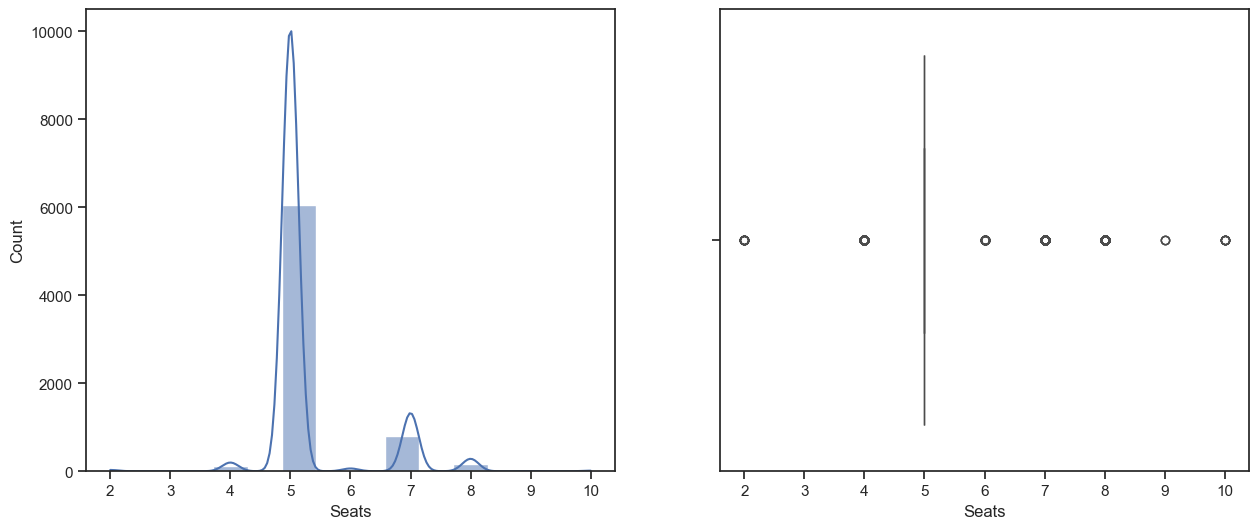

New_price
Skew : 4.13


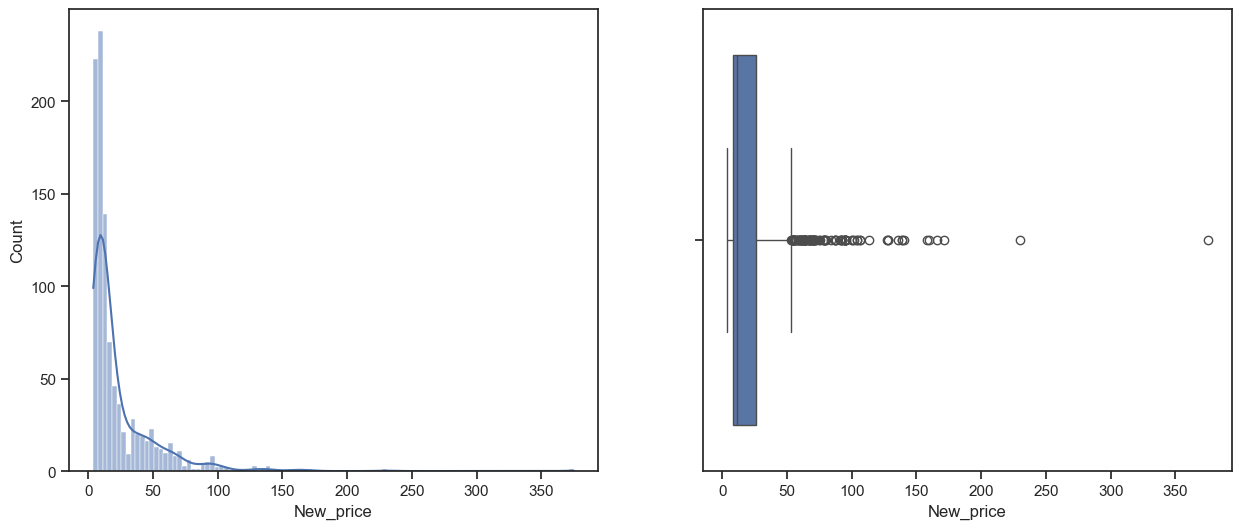

Price
Skew : 3.34


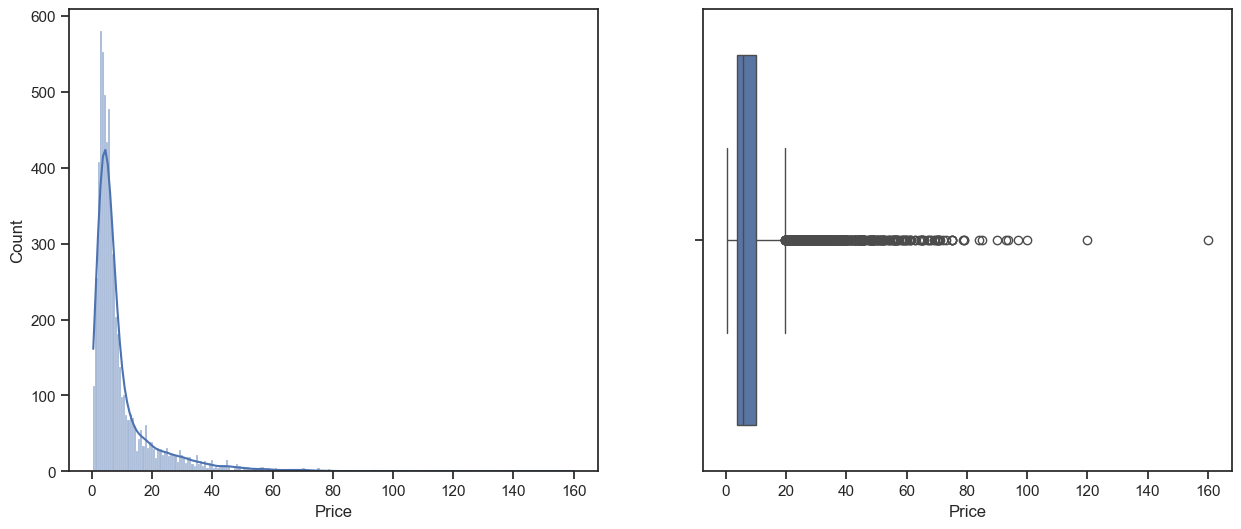

In [137]:
#check for distribution and outliers for each numerical col in data

col_names = list(df_num.columns)

for col in col_names:

  print(col)
  print('Skew :', round(df_num[col].skew(),2))
  fig, ax = plt.subplots(1, 2, figsize = (15, 6))
  sns.histplot(x = df_num[col], ax = ax[0], kde = True);

  sns.boxplot(x = df[col], ax = ax[1]);
  plt.show()


In [138]:
#check % of outliers in numerical columns

for k, v in df_num.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(df_num)[0]
        print("Column %s outliers = %.2f%%" % (k, perc))

Column Year outliers = 0.80%
Column Kilometers_Driven outliers = 3.56%
Column Mileage outliers = 1.37%
Column Engine outliers = 0.90%
Column Power outliers = 3.76%
Column Seats outliers = 99.27%
Column New_price outliers = 1.49%
Column Price outliers = 9.90%


# Observations

- A majority of cars lie within 50,000 to 100,000 km driven but there are several very high outliers
- Many of our numerical columns have a good amount of outliers, usually with higher values (Kilometers_Driven, Engine, Power, Seats, New_price, and Price)
- Kilometers_Driven, Engine, Power, Seats, New_price and Price are all highly skewed towards the right side (>1). Year has a somewhat negative skew towards the left (-0.84)

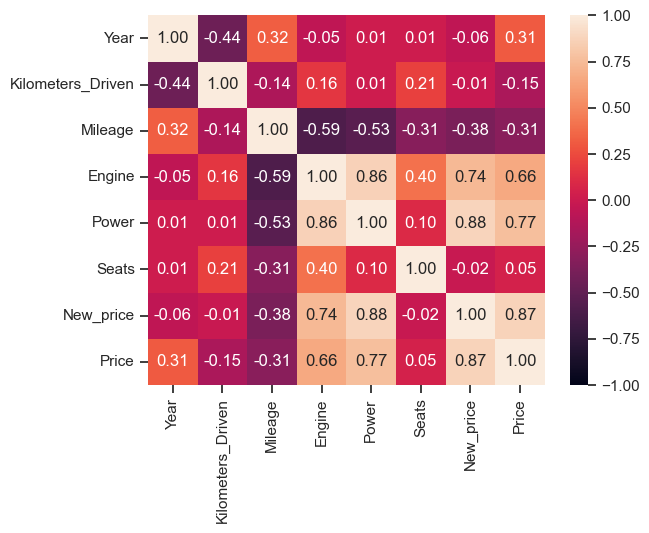

In [139]:
sns.heatmap(df.corr(numeric_only = True), annot = True, vmin = -1, vmax = 1, fmt = '.2f');
plt.show()


# Observations

**Variables with a strong positive correlation (> 0.7):**

- Engine & Power are strongly correlated to the point it may be worth treating them as one variable. A stronger engine has greater power
- Engine & New_Price, a better engine likely boosts the price a new car can be sold at
- Power & New_Price, higher power likely also boosts the price a new car can be sold at
- Power & Price, power seems to have staying power even in relation to resale price
- New_Price and Price, these are also strongly correlated which makes sense as a car that is originally sold at a high price is more likely to still retain a better resale price. That said, New_Price is the variable with the largest amount of null values (~86%) so I may end up having to drop it despite its relevance, or highly modify it


**There are no numerical variables with a strong negative correlation (< -0.7)**

Other notes:
- Engine & Price have a slight (+) correlation (.66). A better engine likely gives a slight boost to a car's resale value.
- Mileage & Engine and Mileage & Power have a slight (-) correlations (-.59 and -.53 respectively). This makes sense as Engine & Power are highly correlated with each other. It could be that cars often sacrifice Engine and Power to achieve better Mileage.

**Note:** While there are some strong correlations between Price and our numerical values there is not as many as you would normally expect, which indicates that there is likely a lot of predictive power held within our categorical values as well


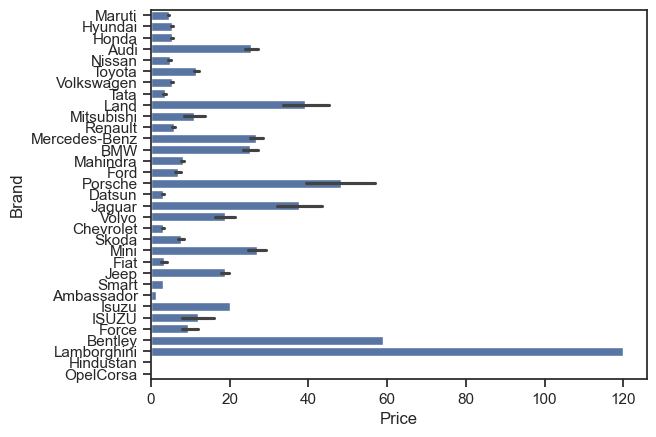

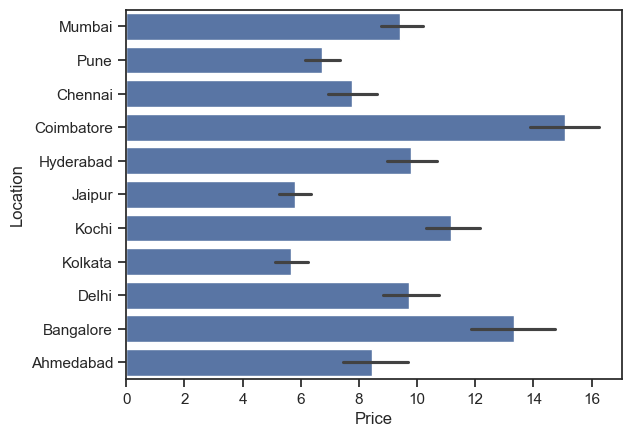

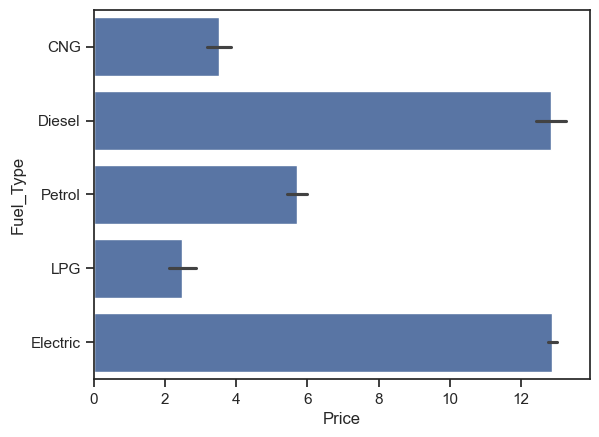

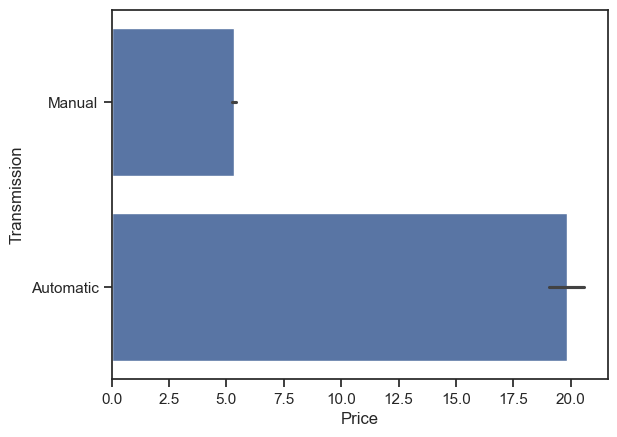

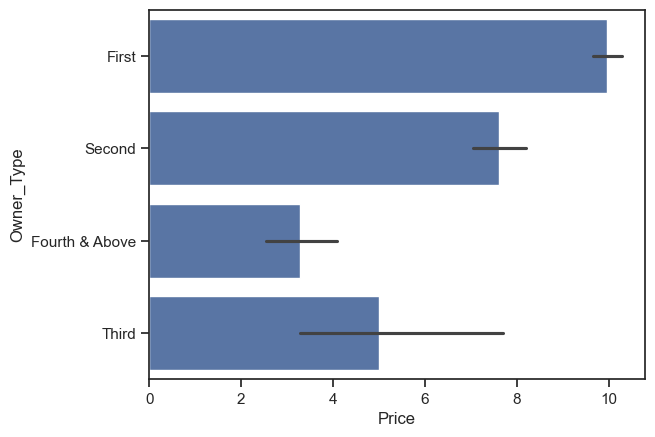

In [140]:
#view categorical col vs. price

df_cat_list = ['Brand', 'Location', 'Fuel_Type', 'Transmission', 'Owner_Type']

for col in df_cat_list:
  sns.barplot(x = 'Price', y = col, data = df)
  plt.show()

# Observations

- Cars from more expensive brands such as Lamborghini and Bentley have a higher resale price
-Cars sold from the Coimbatore and Bangalore locations sell at higher prices. Is it that the locations themselves price cars higher or is that they are more likely to sell luxury brands?
- Diesel and Electric cars have higher prices. It could be again that they are higher in demand or perhaps contain more expensive brands
- Automatic cars resale for higher than Manual
- The more owners a car has the lower the resale price it is likely to be sold for. As an increase in owners can be interpreted as greater wear and tear and use on the car, it makes sense that the cars value is implied to decrease every time it changes hands

------------------------------------------------------------------------------------------------------------------------
Brand v. Location
------------------------------------------------------------------------------------------------------------------------


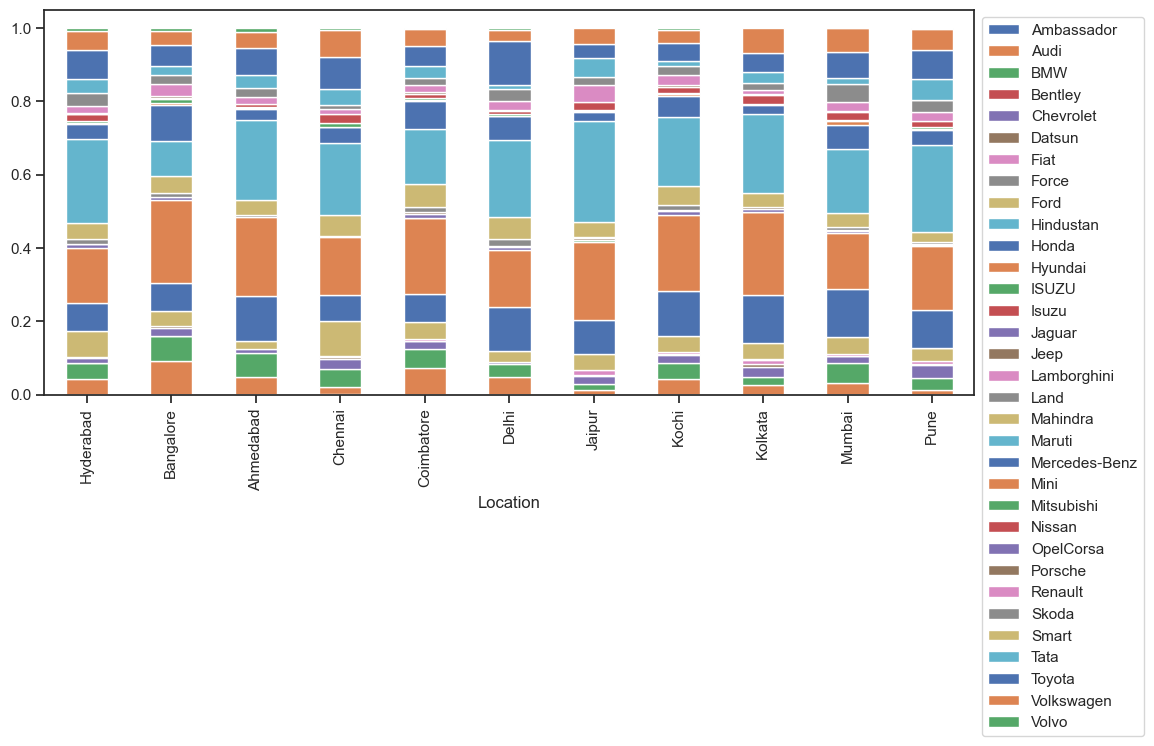

------------------------------------------------------------------------------------------------------------------------
Owner Type v. Location
------------------------------------------------------------------------------------------------------------------------


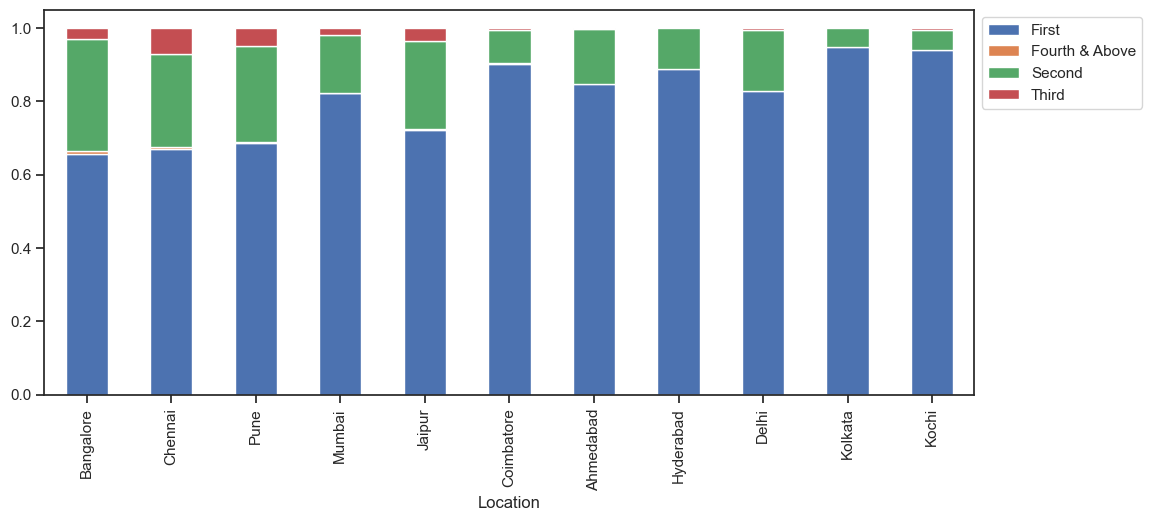

------------------------------------------------------------------------------------------------------------------------
Transmission v. Location
------------------------------------------------------------------------------------------------------------------------


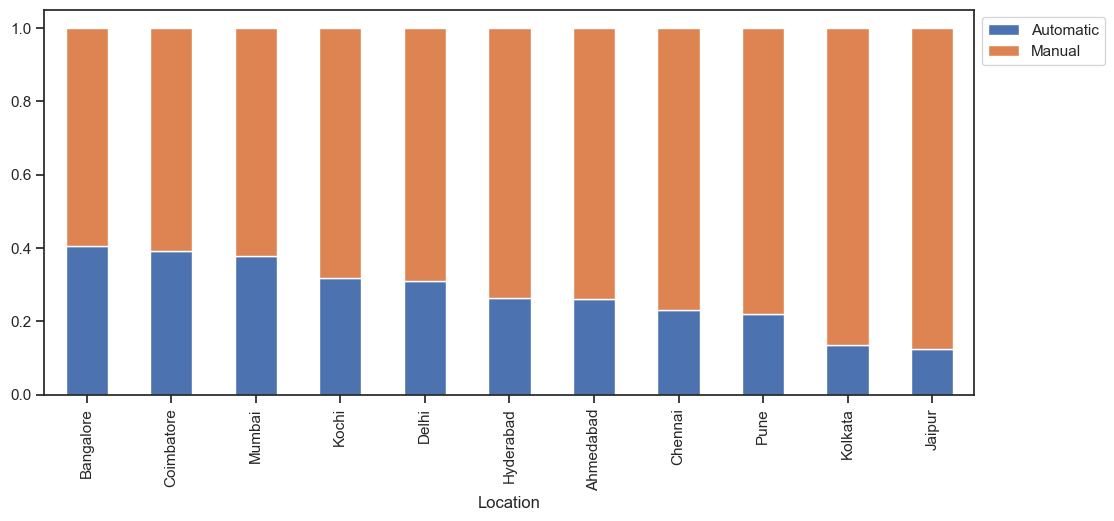

In [141]:
#view brands, ownership and transmission type by location

def stacked_barplot(data, predictor, target):
  """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
  """
  count = data[predictor].nunique()
  sorter = data[target].value_counts().index[-1]
  tab1 = pd.crosstab(data[predictor], data[target], margins = True).sort_values(
      by = sorter, ascending = False
  )
  #print(tab1)
  print("-" * 120)
  tab = pd.crosstab(data[predictor], data[target], normalize = "index").sort_values(
      by = sorter, ascending = False
  )
  tab.plot(kind = "bar", stacked = True, figsize = (count + 1, 5))
  plt.legend(
      loc = "lower left",
      frameon = False,
  )
  plt.legend(loc = "upper left", bbox_to_anchor = (1, 1))
  plt.show()
print("-" * 120)
print('Brand v. Location')
stacked_barplot(df, 'Location', 'Brand')
print("-" * 120)
print('Owner Type v. Location')
stacked_barplot(df, 'Location', 'Owner_Type')
print("-" * 120)
print('Transmission v. Location')
stacked_barplot(df, 'Location', 'Transmission')

# Observations

- There is no strong pattern in which locations sell which Brands that could explain why certain locations tend to have higher priced cars
- Kolkata and Kochi are the locations that sell the most cars on their first ownership, but all locations have a more than half their cars on their first ownership. In addition, Bangalore ranks fairly high on the pricing yet has the largest amount of second and above owned cars
- all locations have a majority of manual transmission cars
- From a glance, the Brand, Ownership_Type and Transmission features cannot fully explain why certain locations tend to have higher priced cars

Price v. Year


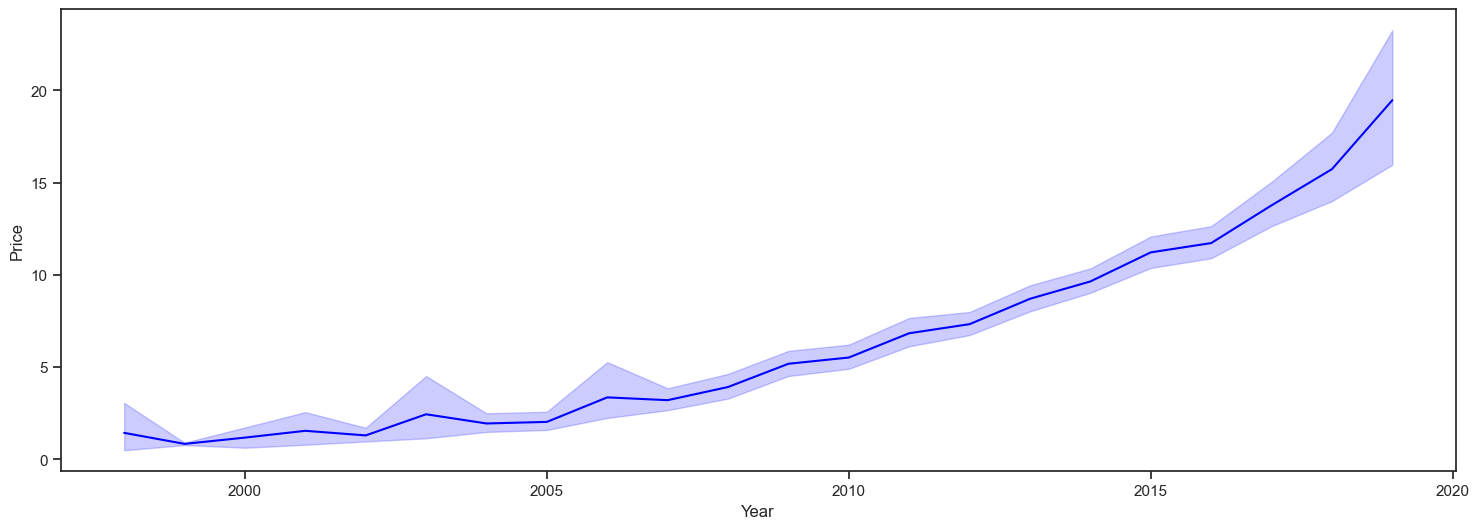

Price v. Engine
Price v. Power
Price v. New_price


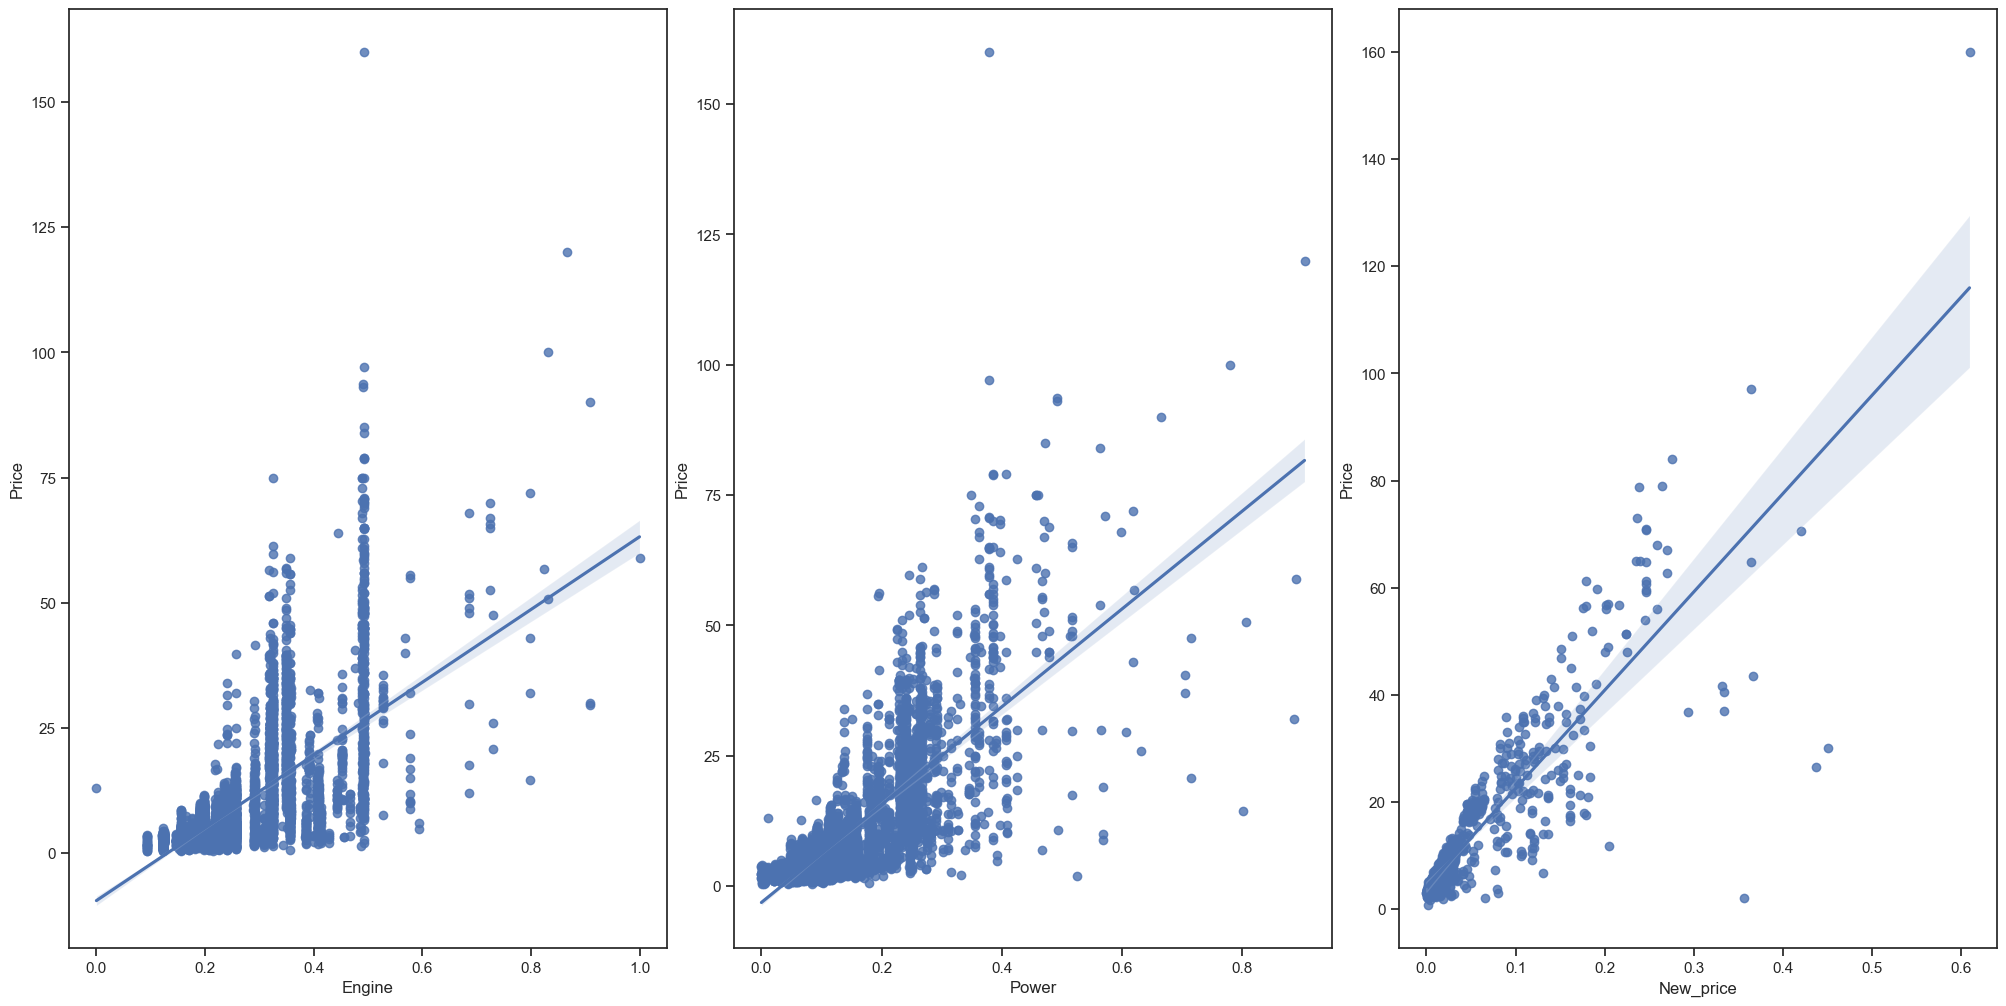

In [142]:
#plot time variable vs. price

print('Price v. Year')
fig = plt.figure(figsize = (18, 6))
sns.lineplot(x = 'Year', y = 'Price', data = df, color = 'blue');
plt.show()

#our correlation matrix shows that Engine, Power and New_price have a >.5 correlation
#with Price so lets transform and plot those

from sklearn import preprocessing
# Let's scale the columns before plotting them against MEDV
min_max_scaler = preprocessing.MinMaxScaler()
column_sels = ['Engine', 'Power', 'New_price']
x = df.loc[:,column_sels]
y = df['Price']
x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=column_sels)
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20, 10))
index = 0
axs = axs.flatten()
for i, k in enumerate(column_sels):
    print(f'Price v. {column_sels[i]}')
    sns.regplot(y=y, x=x[k], ax=axs[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [143]:
#remove skewness from data

df['Price'] = np.log1p(df['Price'])
for col in x.columns:
  if np.abs(x[col].skew()) > 0.3:
    df[col] = np.log1p(x[col])

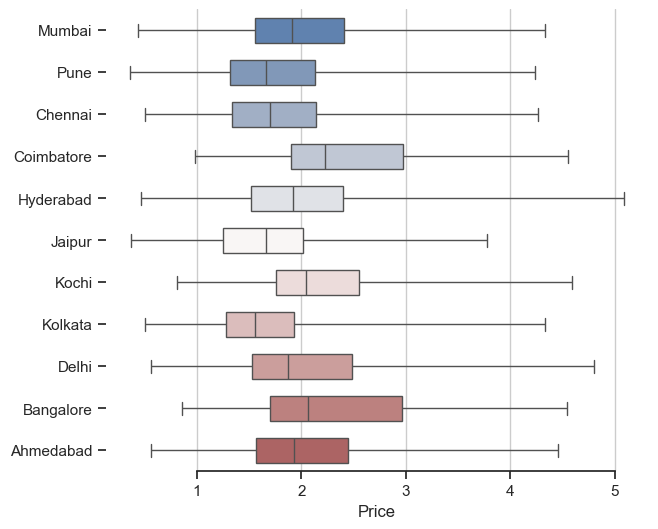

In [144]:
#check price v. location

sns.set_theme(style = 'ticks')

#Initialize the figure w/ a logarithmic x axis
f, ax = plt.subplots(figsize = (7,6))

sns.boxplot(data = df, x = 'Price', y = 'Location', hue = 'Location', width = .6, whis= [0, 100], palette = 'vlag')

ax.xaxis.grid(True)
ax.set(ylabel = '')
sns.despine(trim = True, left = True)

# Observations

- price correlates somewhat positively with year with some variation. Newer cars likely have better resale value
- log transformed multiple numerical columns that showed a strong positive correlation with the target variable (Engine, Power,  New_price)
- the boxplot of Location v. Price indicates that Coimbatore and Bangalore locations have cars with higher prices however there is so much variation within each location that it is hard to make any definitive statements with this plot


### **Missing value treatment**

In [145]:
#We have a lot of missing data within this dataset
#so lets check the % missing in each column and
#also treat some of those missing vals
pd.DataFrame(
    {
        'Count' : df.isnull().sum()[df.isnull().sum() > 0], #view # of missing vals per col
        'Percentage' : ((df.isnull().sum()[df.isnull().sum() > 0] / df.shape[0]) *100).round(2)

    }
)

#The majority of missing values comes from the New_Price col at ~86%
#next largest is Price (~17%) and then Power (~2%)

,Count,Percentage
Mileage,2,0.03
Engine,47,0.65
Power,176,2.43
Seats,53,0.73
New_price,6246,86.13
Price,1233,17.00


- New_Price and Price have the highest number of missing values
- Mileage has the least number of missing values
- Engine and Seats have an almost equal percentage of missing values, with Power having slightly more

In [146]:
df.loc[df['Mileage'].isnull() == True] #view rows with missing values

df.loc[df['Engine'].isnull() == True, 'Name'].value_counts(dropna = False)
df.loc[df['New_price'].isnull() == True, 'Power'].value_counts(dropna = False)
df.loc[df['New_price'].isnull() == True, 'Price'].value_counts(dropna = False)
df.loc[df['New_price'].isnull() == True, 'Seats'].value_counts(dropna = False)

Seats
5.0     5216
7.0      658
8.0      157
4.0      102
NaN       53
6.0       33
2.0       16
10.0       8
9.0        3
Name: count, dtype: int64

- All NA values in Seats and Power are also missing New_price, and a majority of records that are missing Price are also missing New_price (1051 out of 1233). There is no overlap between missing Mileage or Engine and missing New_Price values

In [147]:
#view missing values by Name column using the assumption that if it is the same car and model,
#it should have similar values for Engine, Power and Seats
df.loc[df['Engine'].isnull() == True, 'Name'].value_counts(dropna = False)
df.loc[df['Power'].isnull() == True, 'Name'].value_counts(dropna = False)
df.loc[df['Seats'].isnull() == True, 'Name'].value_counts(dropna = False)

df_select = df.groupby(['Name'])[['Engine', 'Power', 'Seats']].mean()
df_select

df['Engine'] = df['Engine'].fillna(value = df.groupby(['Name'])['Engine']. transform('mean'))
df.loc[df['Engine'].isnull() == True] #view rows with missing values
df['Power'] = df['Power'].fillna(value = df.groupby(['Name'])['Power']. transform('mean'))
df['Seats'] = df['Seats'].fillna(value = df.groupby(['Name'])['Seats']. transform('mean'))

#we have decreased some of the missing values using this method but not all, so we widen
#our criteria and begin to fill missing values using  Brand

df['Engine'] = df['Engine'].fillna(
    value = df.groupby(['Brand'])['Engine'].transform('mean')
)
df['Power'] = df['Power'].fillna(
    value = df.groupby(['Brand'])['Power'].transform('mean')
)
df['Seats'] = df['Seats'].fillna(
    value = df.groupby(['Brand'])['Seats'].transform('mean')
)
df['Mileage'] = df['Mileage'].fillna(
    value = df.groupby(['Brand'])['Mileage'].transform('mean')
)

#view 2 remaining NA values in Power col
print(df[df['Power'].isnull() == True])

#View any other cars with the same brand
print(df[df['Brand'] == 'Smart'])
df[df['Brand'] == 'Hindustan']

#Because these are only two datapoints and they have several missing values in other columns as well
#and no other records share the same brands to base them off of, we will drop these

df[df['Power'].isnull()] #view rows with missing data, it is 915 and 6216

df = df.drop([915, 6216]).reset_index(drop = True) #drop missing values


                                   Name Location  Year  Kilometers_Driven  \
915                 Smart Fortwo CDI AT     Pune  2008             103000   
6216  Hindustan Motors Contessa 2.0 DSL     Pune  1996              65000   

     Fuel_Type Transmission Owner_Type  Mileage    Engine  Power  Seats  \
915     Diesel    Automatic     Second      0.0  0.115718    NaN    2.0   
6216    Diesel       Manual     Second     14.1  0.281037    NaN    5.0   

      New_price     Price      Brand  
915         NaN  1.386294      Smart  
6216        NaN       NaN  Hindustan  
                    Name Location  Year  Kilometers_Driven Fuel_Type  \
915  Smart Fortwo CDI AT     Pune  2008             103000    Diesel   

    Transmission Owner_Type  Mileage    Engine  Power  Seats  New_price  \
915    Automatic     Second      0.0  0.115718    NaN    2.0        NaN   

        Price  Brand  
915  1.386294  Smart  


In [148]:
#check our work to confirm that we have filled all missing values
#for Mileage, Power, Seats and Engine
pd.DataFrame(
    {
        'Count' : df.isnull().sum()[df.isnull().sum() > 0], #view # of missing vals per col
        'Percentage' : ((df.isnull().sum()[df.isnull().sum() > 0] / df.shape[0]) *100).round(2)

    }
)

df =df.drop(['New_price'], axis = 1)
df_new = df[df['Price'].notnull()]
df_new.shape
df_new.head()

#drop the name column now to prep our data for model building
df_new = df_new.drop('Name', axis = 1) #dropped name

### Notes:

There is a large amount of data missing from the New_price column
I chose to drop it although there is a strong correlation between
it and our dependent variable (Price) because of how much is missing
additionally, I will drop the missing price rows as well because it is not recommended to impute on your target variable.

## **Important Insights from EDA and Data Preprocessing**

# Insights & Observations

General Information:

- This data set contains in total 33 brands, 11 locations, 5 fuel types, 2 transmission types and 4 owner types, as well as 2041 names. None of our categorical columns contain missing values
- The names column is likely not going to be a useful predictor for this dataset as there are too many unique values. I ended up extracting the Brand info to create a new column (Brand) which will be much easier to work with
- Data cleaning: removed one duplicate value, filled missing values found in Mileage, Engine, Power and Seats columns, dropped New_price column due to a large amount of missing data ( around 86% missing) and dropped records that were missing values of the target variable Price ( around 17% records dropped)
- multiple features in dataset had a high skew, ended up log transforming Engine, Power, New_price and target variable Price
----

Univariate Analysis:

- Cars in this dataset were made in years spanning 1996 to 2019
- The average amount of km driven  is ~57,000
- Both the average and median car Mileage is ~18 kmpl
- The average power displacement is ~1616 bhp
- The average and most frequent amount of seats in a car is 5
- On average, it appears that the Price of a car is sold for is around half of what its original New_price is.
- On average, the sale price of used cars is ~947,000 INR

----

Bivariate Analysis:

- Diesel and Electric cars have higher prices. It could be again that they are higher in demand or perhaps contain more expensive brands
- Automatic cars resale for higher than Manual
- The more owners a car has the lower the resale price it is likely to be sold for. As an increase in owners can be interpreted as greater wear and tear and use on the car, it makes sense that the cars value is implied to decrease every time it changes hands
- Strong positive correlation between Price and Engine, Power and New_price
- Bangalore and Coimbatore locations have cars with slightly higher price values than other locations but there is a lot of variation within each location
- There is no strong pattern in which locations sell which Brands that could explain why certain locations tend to have higher priced cars
- Kolkata and Kochi are the locations that sell the most cars on their first ownership, but all locations have a more than half their cars on their first ownership. In addition, Bangalore ranks fairly high on the pricing yet has the largest amount of second and above owned cars
all locations have a majority of manual transmission cars

## **Building Models**

In [149]:
#import to build prediction models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor
from sklearn.linear_model import LinearRegression
# To encode categorical variables
from sklearn.preprocessing import LabelEncoder

# For tuning the model
from sklearn.model_selection import GridSearchCV

In [150]:
#Create dummy variables for the categorical columns
#drop_first = True used to avoid redundant variables

df_new = pd.get_dummies(
    df_new,
    columns = df_new.select_dtypes(include = 'object').columns,
    drop_first = True,
)

### **Split the Data**

In [151]:
#drop target variable and Kilometers_Driven (low correlation)
x = df_new.drop(['Price', 'Kilometers_Driven'], axis = 1)
y = df_new['Price']

In [152]:
 #import modeling functions and split data
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error

#split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True, random_state = 1)

#check shapes
print("Shape of Training set : ", x_train.shape)
print("Shape of Test set : ", x_test.shape)

Shape of Training set :  (4814, 52)
Shape of Test set :  (1204, 52)


In [153]:
#linear regression
#Function to compute adjusted R-squared

def adj_r2_score(predictors, targets, predictions):
  r2 = r2_score(targets, predictions)
  n = predictors.shape[0]
  k = predictors.shape[1]
  return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

#Function to compute MAPE

def mape_score(targets, predictions):
  return np.mean(np.abs(targets - predictions) / targets) * 100

# Function copute different metrics to check performance of a regression module
def model_performance_regression(model, predictors, target):
  """
  Function to compute different metrics to check regression model performance

  model: regressor
  predictors: independent variables
  target: dependent variable
  """

  pred = model.predict(predictors) #predict using independent variables
  r2 = r2_score(target, pred) #compute R-squared
  adjr2 = adj_r2_score(predictors, target, pred) #compute adjusted R-squared
  rmse = np.sqrt(mean_squared_error(target, pred)) # compute root mean squared error
  mae = mean_absolute_error(target, pred) # compute Mean absolute error
  mape = mape_score(target, pred) # compute mean absolute percentage error

  #Create a df of metrics
  df_perf = pd.DataFrame(
      {
        "RMSE": rmse,
        "MAE": mae,
        "R-squared": r2,
        "Adj. R-squared": adjr2,
        "MAPE": mape,
      },
      index = [0],
  )
  return df_perf

### LinearRegression

In [154]:
# Initialize the model
model = LinearRegression()

# Fit the model on the training data
model.fit(x_train, y_train)

LinearRegression()

In [155]:
linear_reg = model_performance_regression(model, x_train, y_train)
# Check performance on the testing data
linear_reg_test = model_performance_regression(model, x_test, y_test)


### Ridge Regression

In [156]:
#ridge regression
ridge_model = Ridge() #creating ridge regression model
ridge_model.fit(x_train, y_train) #fitting the model

Ridge()

In [157]:
#check values using ridge_regression
ridge_reg = model_performance_regression(ridge_model, x_test, y_test) #getting performance metrics on test data

### Ridge Regression Tuned

In [158]:
#ridge regression with optimized alpha

folds = KFold(n_splits = 10, shuffle = True, random_state = 1)
params = {'alpha':[0.001, 0.01, 0.1, 0.2, 0.5, 0.9, 1, 5,10,20]}
model = Ridge()
model_cv = GridSearchCV(estimator = model, param_grid = params, scoring = 'r2', cv = folds, return_train_score = True)
model_cv.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.2, 0.5, 0.9, 1, 5, 10,
                                   20]},
             return_train_score=True, scoring='r2')

In [159]:
model_cv.best_params_ #getting optimised params for alpha
ridge_model_tuned = Ridge(alpha=0.1) ##creating Tuned Ridge Regression model using optimised alpha value
ridge_model_tuned.fit(x_train, y_train) # Fitting the data into the tuned model
ridge_reg_tuned = model_performance_regression(ridge_model_tuned, x_test, y_test) #getting performance metrics on test data


### Lasso

In [160]:
#trying lasso regression

lasso_model = Lasso()
lasso_model.fit(x_train, y_train)
lasso_reg = model_performance_regression(lasso_model, x_test, y_test)
lasso_reg

lasso_model_tuned = Lasso(alpha=0.001)
lasso_model_tuned.fit(x_train, y_train)
lasso_reg_tuned = model_performance_regression(lasso_model_tuned, x_test, y_test)

### Elastic Net

In [161]:
#finally, lets try elastic net regression

elasticnet_model = ElasticNet()
elasticnet_model.fit(x_train, y_train)

ElasticNet()

In [162]:
#default parameters
elasticnet_reg = model_performance_regression(elasticnet_model, x_test, y_test)

### Elastic Net Tuned

In [163]:
#lets try optimizing the alpha value l1_ratio

folds = KFold(n_splits=10, shuffle=True, random_state=1)
params = {'alpha':[0.001, 0.01, 0.1, 0.2, 0.5, 0.9],
         'l1_ratio': [0.001, 0.01, 0.02, 0.03, 0.04, 0.05]}
model = ElasticNet()
model_cv = GridSearchCV(estimator=model, param_grid=params, scoring='r2', cv=folds, return_train_score=True)
model_cv.fit(x_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=1, shuffle=True),
             estimator=ElasticNet(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.2, 0.5, 0.9],
                         'l1_ratio': [0.001, 0.01, 0.02, 0.03, 0.04, 0.05]},
             return_train_score=True, scoring='r2')

In [164]:
model_cv.best_params_
elasticnet_model_tuned = ElasticNet(alpha=0.001, l1_ratio=0.05)
elasticnet_model_tuned.fit(x_train, y_train)

ElasticNet(alpha=0.001, l1_ratio=0.05)

In [165]:
elasticnet_reg_tuned = model_performance_regression(elasticnet_model_tuned, x_test, y_test)

### View All Tested Regression Models

In [166]:
#viewing all regression test so far

models= pd.concat([linear_reg_test,ridge_reg,ridge_reg_tuned,lasso_reg,lasso_reg_tuned,elasticnet_reg,
                   elasticnet_reg_tuned], axis=0) #combining all models into a single dataframe
models['Models'] = ['Least Squares', 'Ridge Regression', 'Ridge Regression Tuned', 'Lasso Regression',
                                      'Lasso Regression Tuned', 'Elastic Net Regression',
                    'Elastic Net Regression Tuned'] #adding names of the models as a column to the dataframe
models = models.iloc[:,[5, 0,1,2,3,4]] #ordering names of the models as the first column
models

,Models,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,Least Squares,0.191791,0.148513,0.935253,0.932327,8.308196
0,Ridge Regression,0.194340,0.150522,0.933520,0.930517,8.413579
0,Ridge Regression Tuned,0.192045,0.148764,0.935081,0.932148,8.320871
0,Lasso Regression,0.732487,0.571602,0.055583,0.012916,32.307603
0,Lasso Regression Tuned,0.199753,0.154071,0.929766,0.926593,8.629108
0,Elastic Net Regression,0.613616,0.478595,0.337237,0.307294,26.444362
0,Elastic Net Regression Tuned,0.201728,0.156935,0.928370,0.925133,8.771591


# Observations

- least squares (linear regression) gives us the best results compared  to other models
- regularization does not further improve its performance metrics
- both our train and test data have similar R-squared and Adj. 

#### Least Squares:
- R-squared values which indicates that the linear regression model is not overfitting on our training data and also that this model fits our data well with an r-squared of ~0.93
- Adj. R-squared of ~0.93 implies that the independent variables are able to explain ~93% variance in the target variable
- MAE indicates that the current model can predict car resale prices within a mean error of ~0.15 units
- RMSE and MAE are fairly close to each other, with RMSE being higher because it penalizes outliers more
- MAPE is ~8% on the test data, indicating that the average difference between the predicted value and the actual value is around ~8%



### **Hyperparameter Tuning: Decision Tree**

In [167]:
#build a decision tree model

dt = DecisionTreeRegressor(random_state = 1)
dt.fit(x_train, y_train)

#model perfo on test data
dt_regressor_perf_test = model_performance_regression(dt, x_test, y_test)
dt_regressor_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.243652,0.153472,0.895502,0.890781,8.247851


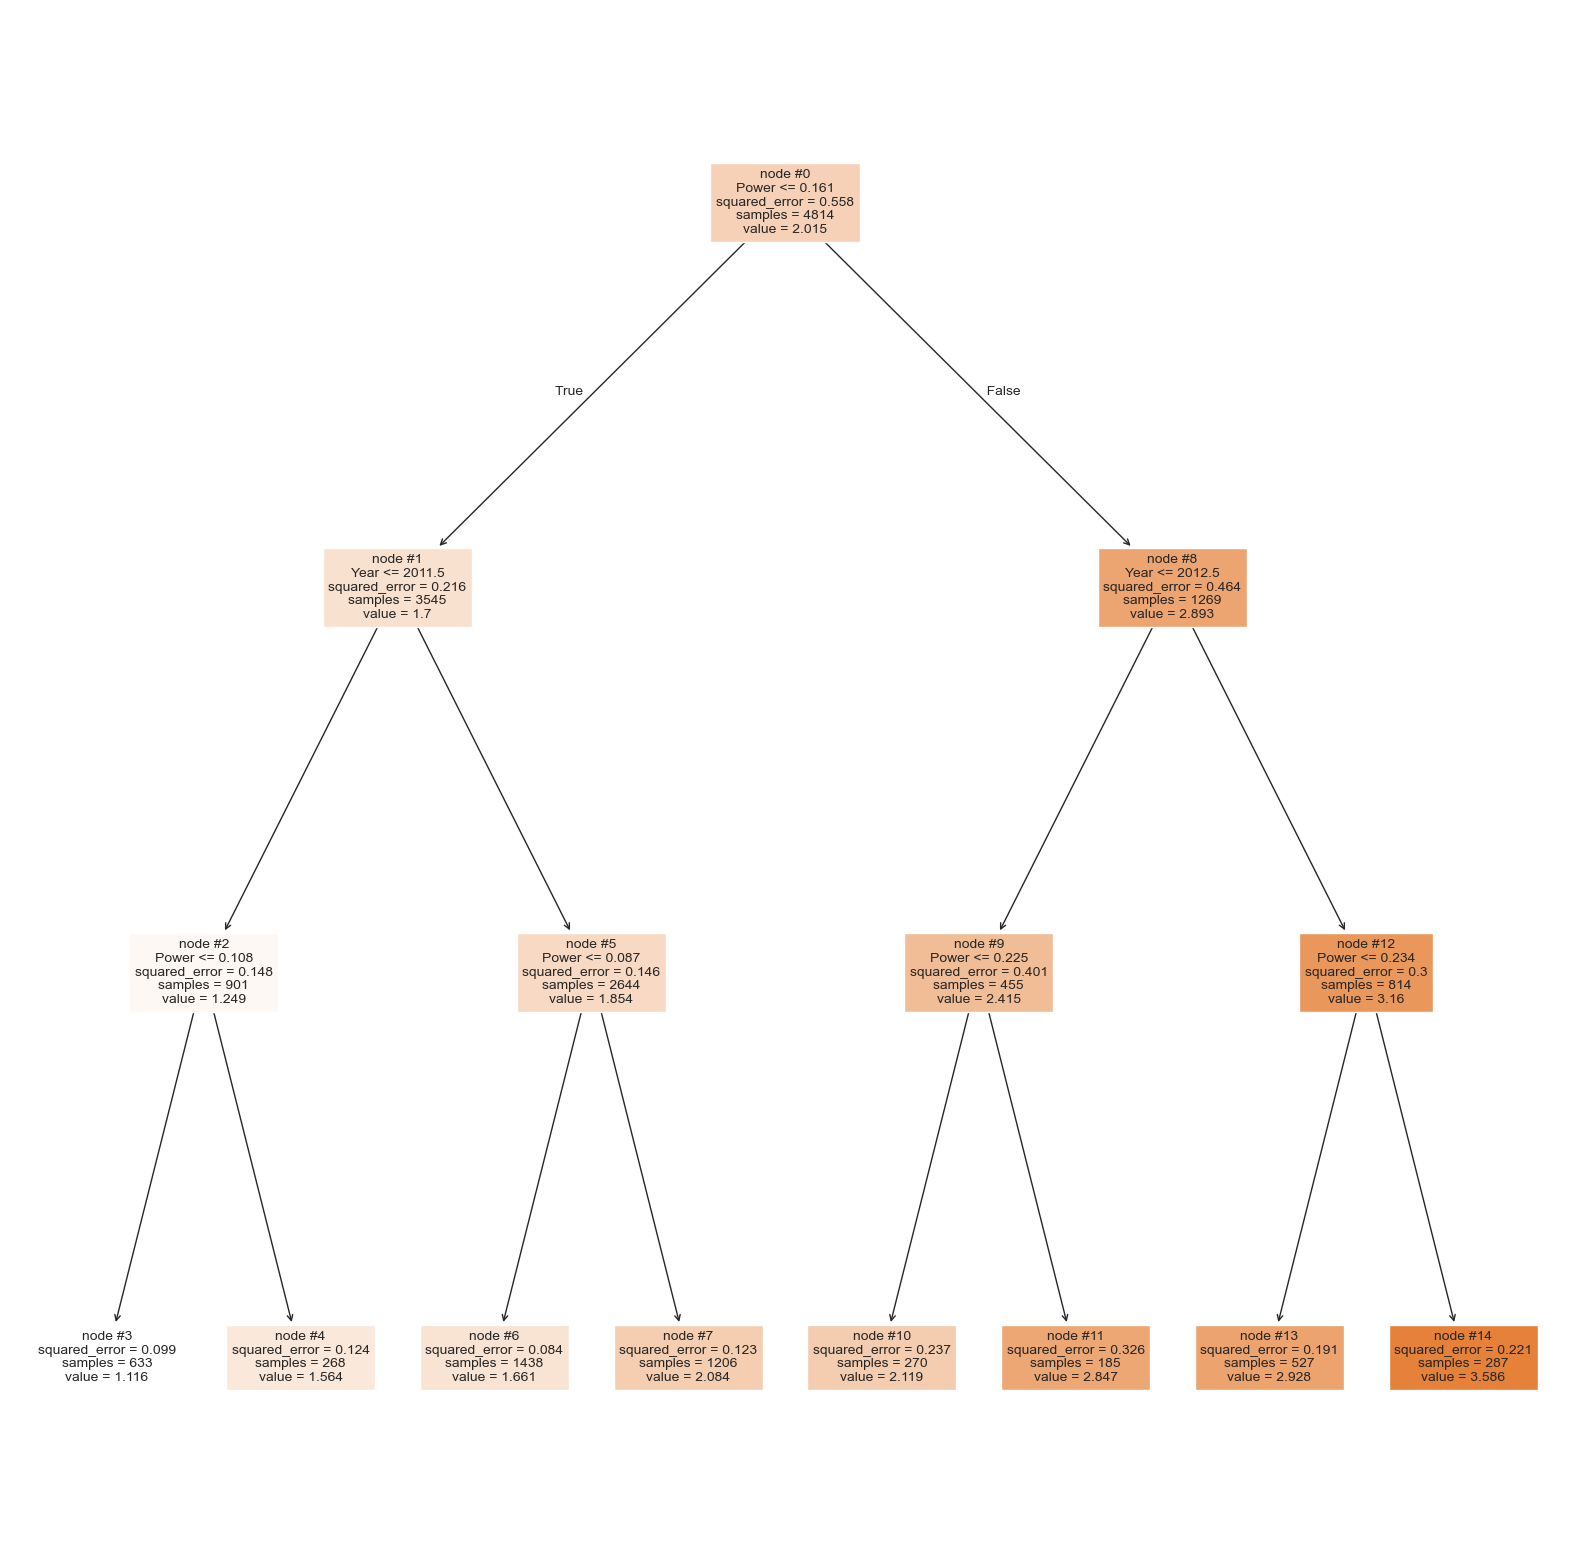

In [168]:
#visualize decision tree
from sklearn import tree

features = list(x.columns)

#building the model with maxdepth = 3

dt_regressor_visualize = DecisionTreeRegressor(random_state = 1, max_depth = 3)
dt_regressor_visualize.fit(x_train, y_train)

plt.figure(figsize = (20, 20))
tree.plot_tree(dt_regressor_visualize, feature_names = features, filled = True, fontsize = 10,
               node_ids = True, class_names = True)
plt.show()

**Plotting Feature Importance**

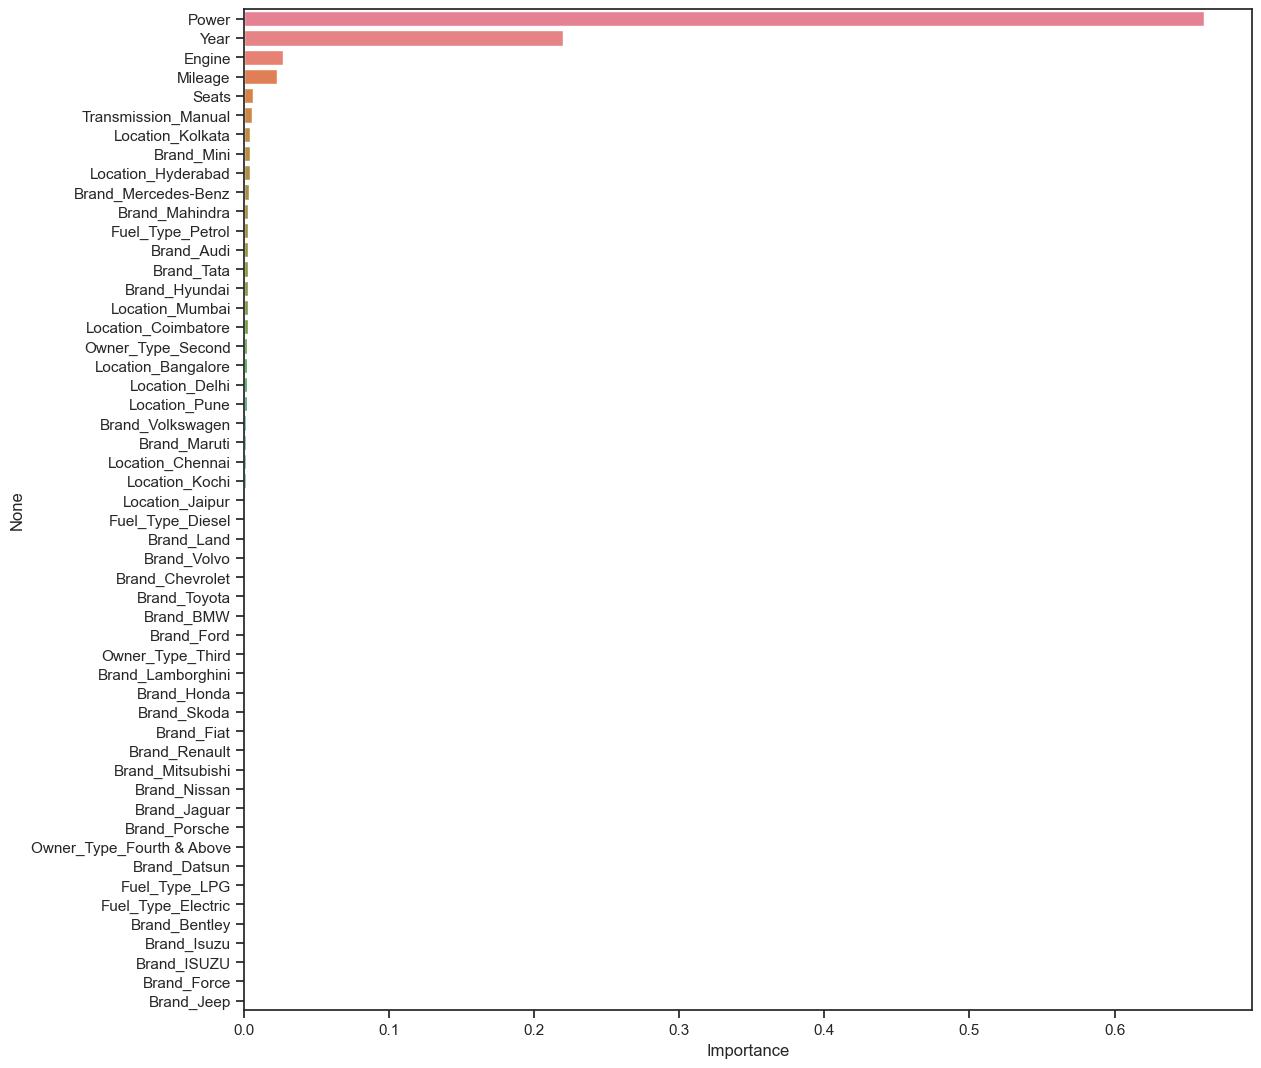

In [169]:
# Plot the feature importance

importances = dt.feature_importances_

columns = x.columns

importance_df = pd.DataFrame(importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

sns.barplot(x=importance_df.Importance,y=importance_df.index, palette = 'husl');


### **Hyperparameter Tuning: Random Forest**

In [170]:
#trying random forest tuning

rf_regressor = RandomForestRegressor(random_state = 1)
rf_regressor.fit(x_train, y_train)

#model performance on test data
rf_regressor_perf_test = model_performance_regression(rf_regressor, x_test, y_test)

rf_regressor_perf_test

,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,0.169891,0.11655,0.949195,0.9469,6.369125


# Observations

- Random forest model is slightly better than our current linear regression model with an R-squared and Adj. R-Squared of ~0.94 (in comparison to previous ~0.93 value)
- also causes a 1% decrease in MAPE
-RMSE and MAE also decrease slightly implying that this model is slightly better predictor than the least squares method-- very cool!

**Feature Importance**

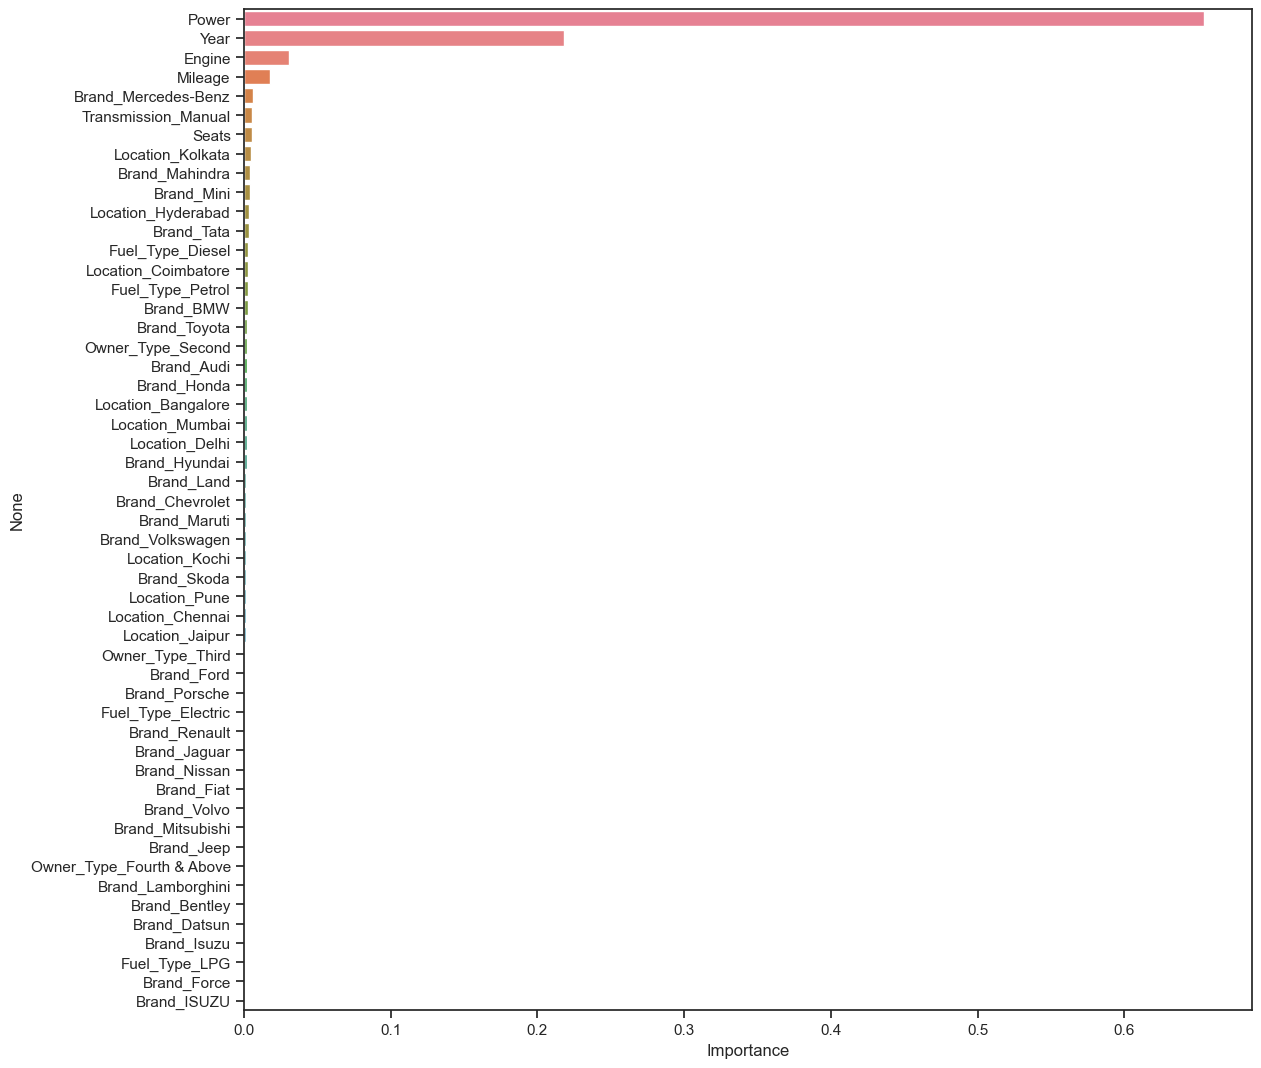

In [171]:

rf_importances = rf_regressor.feature_importances_

columns = x.columns

rf_importance_df = pd.DataFrame(rf_importances, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

sns.barplot(x=rf_importance_df.Importance,y=rf_importance_df.index, palette = 'husl');


# Choosing the final model

In [172]:
#viewing all regression test so far

models= pd.concat([linear_reg_test,ridge_reg,ridge_reg_tuned,lasso_reg,lasso_reg_tuned,elasticnet_reg,
                   elasticnet_reg_tuned, dt_regressor_perf_test, rf_regressor_perf_test], axis=0) #combining all models into a single dataframe
models['Models'] = ['Least Squares', 'Ridge Regression', 'Ridge Regression Tuned', 'Lasso Regression',
                                      'Lasso Regression Tuned', 'Elastic Net Regression',
                    'Elastic Net Regression Tuned', 'Decision Tree Regressor', 'Random Forest Regressor'] #adding names of the models as a column to the dataframe
models = models.iloc[:,[5, 0,1,2,3,4]] #ordering names of the models as the first column
models

,Models,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,Least Squares,0.191791,0.148513,0.935253,0.932327,8.308196
0,Ridge Regression,0.194340,0.150522,0.933520,0.930517,8.413579
0,Ridge Regression Tuned,0.192045,0.148764,0.935081,0.932148,8.320871
0,Lasso Regression,0.732487,0.571602,0.055583,0.012916,32.307603
0,Lasso Regression Tuned,0.199753,0.154071,0.929766,0.926593,8.629108
0,Elastic Net Regression,0.613616,0.478595,0.337237,0.307294,26.444362
0,Elastic Net Regression Tuned,0.201728,0.156935,0.928370,0.925133,8.771591
0,Decision Tree Regressor,0.243652,0.153472,0.895502,0.890781,8.247851
0,Random Forest Regressor,0.169891,0.116550,0.949195,0.946900,6.369125


# Observations:

I propose that the best model is the **Random Forest Regressor model**. The Random Forest Regressor has the **lowest RMSE and MAE**, indicating that the average difference between predicted and actual values is the smallest. It also has a **higher R-squared and Adjusted R-squared**, indicating that the model explains a significant proportion of the variance in the target variable. It also has a low MAPE, indicating that it has a **small average percentage error**.
In addition, it performs well on the test data we can be confident that we are **not overfitting** on the training data.